# Práctica 3 - Clustering

# Ejercicio 1 (Agrupamiento General)

En este cuaderno se desarrolla el Ejercicio 1, centrado en la aplicación de técnicas de clustering no supervisado sobre un conjunto de datos de Pokémon a partir de un archivo JSON. El objetivo es identificar agrupamientos naturales a partir de sus características y analizar si los clusters obtenidos guardan relación con propiedades conocidas del dominio, como los tipos de Pokémon. Este ejercicio se centra en el uso de modelos de agrupamiento general. 

El trabajo se divide en tres fases principales. Primero, se realiza la preparación y exploración de los datos, incluyendo su limpieza, transformación, escalado y representación para permitir el uso de medidas de distancia. Se aplican dos algoritmos de clustering, K-Means y DBSCAN, probando distintas configuraciones de sus parámetros. Finalmente, se evalúan y comparan los resultados obtenidos, analizando la estructura, interpretabilidad y coherencia de los clusters generados.

## Paso 1 - Medio ambiente preparación

En primer lugar, se carga el conjunto de datos en formato JSON y se accede a la sección pokedex, que contiene la información individual de cada Pokémon. Cada entrada de este diccionario representa una instancia del problema y corresponde a un Pokémon concreto. En este paso también cargamos las librerías necesarias para la realización del ejercicio 1. 

In [62]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Definimos posibles nombres del archivo JSON en caso de conflictos
ruta_json = ["pokemons-1.json", "pokemons.json"]

# Buscamos la ruta del archivo JSON real a partir de los posibles nombres del archivo definidos previamente
data_path = None
for p in ruta_json:
    if os.path.exists(p):
        data_path = p
        break
        
# Cargamos el archivo JSON con los datos
with open(data_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

pokedex = raw["pokedex"]

A continuación, el dataset se transforma a un formato tabular, donde cada Pokémon se representa como una fila. La clave del diccionario se utiliza como identificador único (poke_id), mientras que las estadísticas base (hp, atk, def, spa, spd, spe) y la variable hasEvo se incorporan como características numéricas. Estas variables constituyen la base de la representación vectorial que permitirá posteriormente medir distancias entre Pokémon.

Además, se generan algunas variables numéricas derivadas de baja dimensionalidad, como el número de tipos, habilidades y movimientos disponibles (n_types, n_abilities, n_moves) con el objetivo de capturar información estructural adicional sin introducir una dimensionalidad excesiva.

In [63]:
# Campo 'stats' de cada pokemon
STAT_POKEMON = ["hp", "atk", "def", "spa", "spd", "spe"]

# Parseamos los datos a formato tabla (DataFrame)
rows = []
for poke_id, info in pokedex.items():
    info = info if isinstance(info, dict) else {}
    
    stats = info.get("stats", {}) if isinstance(info.get("stats", {}), dict) else {}
    types = info.get("types", []) if isinstance(info.get("types", []), list) else []
    abilities = info.get("abilities", []) if isinstance(info.get("abilities", []), list) else []
    learnset = info.get("learnset", []) if isinstance(info.get("learnset", []), list) else []

    row = {
        # Identificador único
        "poke_id": poke_id,

        # 'Stats' de los pokemon
        "hasEvo": info.get("hasEvo", np.nan),
        **{k: stats.get(k, np.nan) for k in STAT_POKEMON},

        # Variables numéricas derivadas adicionales
        "n_types": len(types),
        "n_abilities": len(abilities),
        "n_moves": len(learnset),

        # Categóricas
        "types": types,
        "abilities": abilities,
        "learnset": learnset,
    }

    rows.append(row)

# Organizamos el dataframe resultante alfabéticamente
df = pd.DataFrame(rows).set_index("poke_id").sort_index()

### Exploración del conjunto de datos 

En esta sección se realiza una exploración inicial del conjunto de datos resultante del apartado anterior con el objetivo de comprender la naturaleza de los datos, como sus características, distribuciones y relaciones. Se analizan las distribuciones de las variables, así como las relaciones existentes entre los distintos atributos y el objetivo implícito del ejercicio, que es identificar patrones coherentes entre los Pokémon.

Como primer paso, se obtiene una visión general del DataFrame resultante mediante funciones descriptivas básicas. El uso de df.head(), df.describe() y df.info() permite comprobar la estructura de los datos, el tipo de cada variable, la presencia de valores ausentes entre otras, sirviendo como punto de partida para la exploración del conjunto de datos y como referencia para identificar posibles acciones necesarias en el preprocesamiento de datos para limpiar el dataframe antes del entrenamiento. 

In [64]:
df.head()

,hasEvo,hp,atk,def,spa,spd,spe,n_types,n_abilities,n_moves,types,abilities,learnset
poke_id,,,,,,,,,,,,,
abomasnow,0,90,92,75,92,85,60,2,2,57,"[Grass, Ice]","[Snow Warning, Soundproof]","[lightscreen, avalanche, endure, powdersnow, r..."
abra,1,25,20,15,105,55,90,1,3,57,[Psychic],"[Synchronize, Inner Focus, Magic Guard]","[lightscreen, wonderroom, allyswitch, sunnyday..."
absol,0,65,130,60,75,60,75,1,3,73,[Dark],"[Pressure, Super Luck, Justified]","[sunnyday, endure, detect, assurance, darkpuls..."
accelgor,0,80,70,40,100,60,145,1,3,49,[Bug],"[Hydration, Sticky Hold, Unburden]","[toxicspikes, endure, raindance, yawn, substit..."
aegislash,0,60,50,140,50,140,60,2,1,45,"[Steel, Ghost]",[Stance Change],"[sunnyday, autotomize, irondefense, endure, ra..."


La salida de df.head() permite comprobar de forma rápida que el conjunto de datos se ha cargado y estructurado correctamente. Cada fila representa un Pokémon único, y las columnas muestran de forma coherente tanto las variables numéricas como las variables categóricas. A primera vista, los valores de las estadísticas, los contadores derivados y las listas de tipos, habilidades y movimientos presentan un formato consistente, lo que sugiere que el proceso de importación y parseo del JSON se ha realizado correctamente.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 734 entries, abomasnow to zygardecomplete
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hasEvo       734 non-null    int64 
 1   hp           734 non-null    int64 
 2   atk          734 non-null    int64 
 3   def          734 non-null    int64 
 4   spa          734 non-null    int64 
 5   spd          734 non-null    int64 
 6   spe          734 non-null    int64 
 7   n_types      734 non-null    int64 
 8   n_abilities  734 non-null    int64 
 9   n_moves      734 non-null    int64 
 10  types        734 non-null    object
 11  abilities    734 non-null    object
 12  learnset     734 non-null    object
dtypes: int64(10), object(3)
memory usage: 80.3+ KB


La salida de df.info() muestra que el conjunto de datos está compuesto por 734 Pokémon (filas), cada uno identificado de forma única, y 13 columnas (variables) en total. No se detectan valores nulos en ninguna de las variables, lo que indica que será necesario aplicar técnicas adicionales de imputación y tratamiento de valores faltantes en el preprocesamiento de datos.

Las variables numéricas corresponden a las estadísticas base de combate, la variable binaria hasEvo y las variables agregadas (n_types, n_abilities, n_moves), todas ellas almacenadas como enteros. Por otro lado, las columnas types, abilities y learnset se almacenan como objetos, ya que contienen listas de valores categóricos.

In [66]:
df.describe()

,hasEvo,hp,atk,def,spa,spd,spe,n_types,n_abilities,n_moves
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,0.418256,70.539510,78.540872,75.257493,71.779292,72.600817,67.367847,1.544959,2.361035,53.174387
std,0.493609,28.199599,30.708378,30.775124,30.869621,27.690948,29.341353,0.498314,0.770646,16.510019
min,0.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,1.000000,0.000000
25%,0.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,1.000000,2.000000,46.000000
50%,0.000000,68.000000,75.000000,70.000000,65.000000,70.000000,65.000000,2.000000,3.000000,53.000000
75%,1.000000,85.000000,100.000000,95.000000,95.000000,90.000000,90.000000,2.000000,3.000000,61.000000
max,1.000000,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,2.000000,4.000000,235.000000


La salida de df.describe() proporciona un resumen estadístico de las variables numéricas del conjunto de datos. En ella se muestran, para cada característica, medidas básicas como el número de observaciones, la media, la desviación estándar, percentiles y los valores mínimo y máximo. Este resumen permite obtener una primera idea de la escala, variabilidad y rango de las estadísticas de los Pokémon y de las variables agregadas incluidas en el análisis.

A partir de estos valores se observa que las estadísticas base presentan rangos amplios y variabilidad significativa, lo que refuerza la necesidad de aplicar técnicas de escalado antes de utilizar modelos de clustering basados en distancia. También observamos la posible presencia de valores atípicos (outliers) lo cual debemos verificar y tratar, si es adecuado, en la fase de preprocesamiento de nuestros datos.

### Estudio de Distribuciones

En esta subsección se analizan las distribuciones de las variables numéricas del conjunto de datos con el objetivo de comprender su rango, variabilidad y forma, además de anticipar decisiones de preprocesamiento necesarias para los algoritmos de clustering basados en distancia.

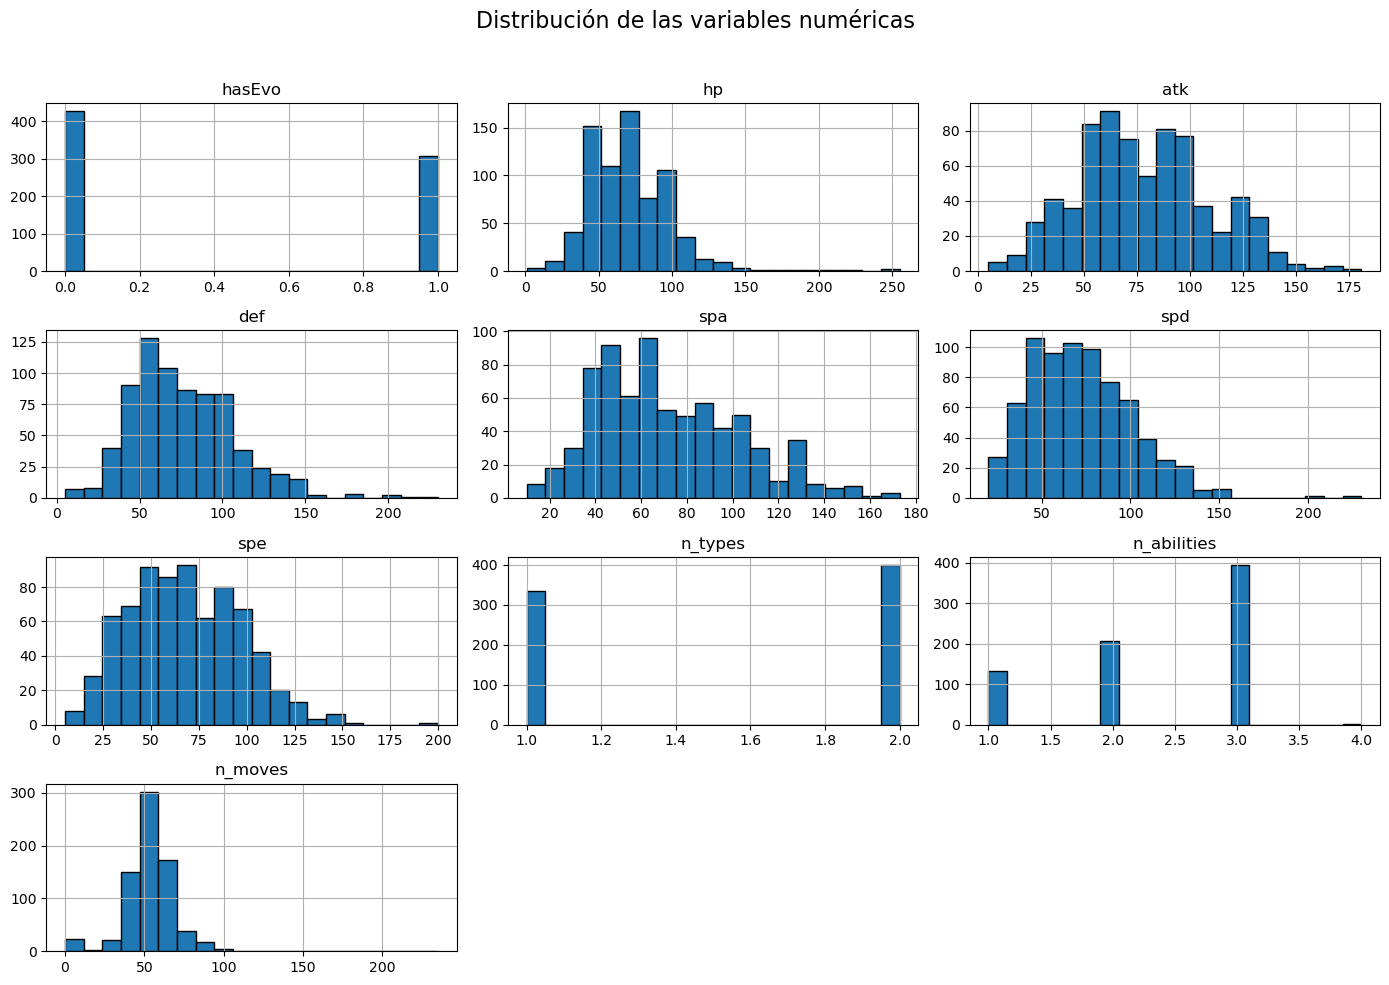

In [67]:
num_cols = df.select_dtypes(include=[np.number]).columns

df[num_cols].hist(
    figsize=(14, 10),
    bins=20,
    edgecolor="black"
)

plt.suptitle("Distribución de las variables numéricas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Las distribuciones de las variables hasEvo, n_types y n_abilities indican que se trata de características discretas con un rango muy limitado de valores posibles. En particular, hasEvo es una variable binaria que únicamente toma los valores 0 o 1, mientras que n_types y n_abilities solo pueden adoptar dos o tres valores distintos, respectivamente. Como consecuencia, estas variables presentan una capacidad limitada para aportar información diferenciadora en el análisis.

No obstante, se observan ciertos patrones descriptivos de interés. En el caso de hasEvo, existe un mayor número de Pokémon que no presentan evolución, aunque la proporción entre ambos grupos es relativamente equilibrada. De forma similar, la variable n_types muestra una ligera predominancia de Pokémon con dos tipos frente a aquellos con un solo tipo, manteniendo también una distribución bastante balanceada. Por último, la variable n_abilities revela que la mayoría de los Pokémon disponen de tres habilidades, mientras que una proporción menor presenta dos habilidades y un número reducido cuenta únicamente con una habilidad.

Para observar esta información de manera más precisa, a continuación se muestran las cantidades de cada categoría y su proporción de las variables hasEvo, n_types y n_abilities. 

In [68]:
# hasEvo: valores absolutos y porcentajes
hasEvo_counts = df["hasEvo"].value_counts().sort_index()
hasEvo_percent = df["hasEvo"].value_counts(normalize=True).sort_index() * 100

hasEvo_summary = pd.DataFrame({
    "count": hasEvo_counts,
    "percentage": hasEvo_percent.round(1)
})

hasEvo_summary

,count,percentage
hasEvo,,
0,427,58.2
1,307,41.8


In [69]:
# n_types: valores absolutos y porcentajes
n_types_counts = df["n_types"].value_counts().sort_index()
n_types_percent = df["n_types"].value_counts(normalize=True).sort_index() * 100

n_types_summary = pd.DataFrame({
    "count": n_types_counts,
    "percentage": n_types_percent.round(1)
})

n_types_summary

,count,percentage
n_types,,
1,334,45.5
2,400,54.5


In [70]:
# n_abilities: valores absolutos y porcentajes
n_abilities_counts = df["n_abilities"].value_counts().sort_index()
n_abilities_percent = df["n_abilities"].value_counts(normalize=True).sort_index() * 100

n_abilities_summary = pd.DataFrame({
    "count": n_abilities_counts,
    "percentage": n_abilities_percent.round(1)
})

n_abilities_summary

,count,percentage
n_abilities,,
1,132,18.0
2,206,28.1
3,395,53.8
4,1,0.1


El resto de las variables númericas presentan distribuciones relativamente simétricas (medias y medianas de valores similares) centradas alrededor de sus respectivas medias. Las distribuciones de las estadísticas son anchas, lo que indica que estas variables toman un rango amplio de valores. 

### Estudio de Correlaciones

En esta subsección se analizan las relaciones existentes entre las variables del conjunto de datos, con el objetivo de identificar posibles dependencias y patrones relevantes antes de aplicar los algoritmos de clustering. En primer lugar, se estudia la correlación entre las variables numéricas. A continuación, se explora la relación entre las estadísticas base (stats) y el objetivo implícito del ejercicio, representado por el tipo principal de cada Pokémon para observar hasta qué punto las características numéricas reflejan información relevante.

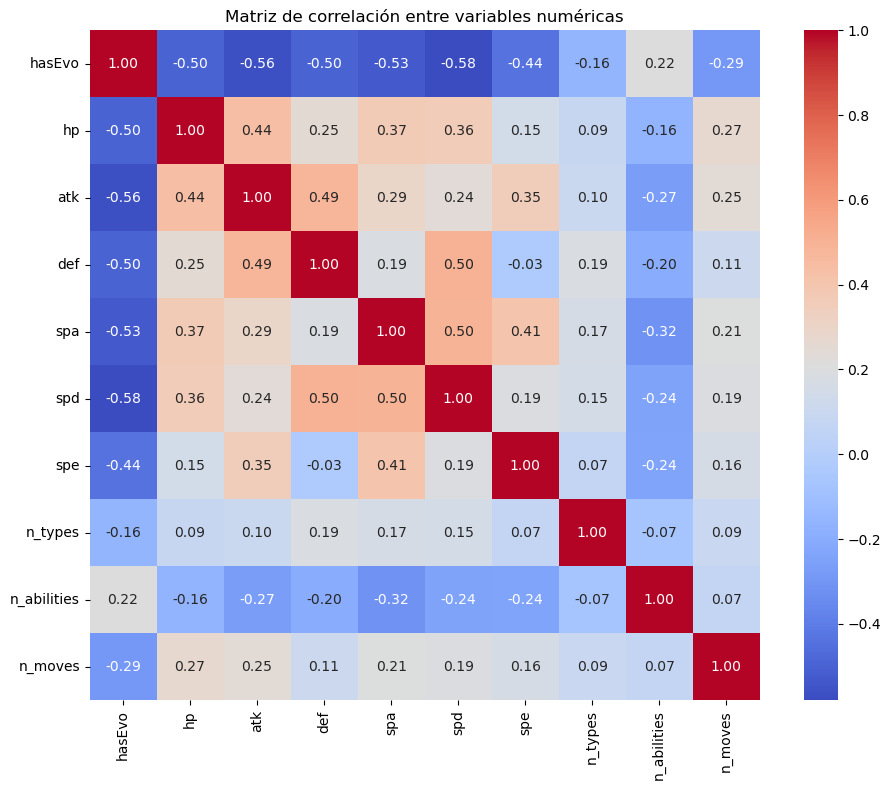

In [71]:
num_cols = df.select_dtypes(include=[np.number]).columns

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

Se observan correlaciones moderadas entre algunas de las estadísticas base, como atk, def, spa y spd, lo cual es esperable dado que reflejan atributos relacionados con el rendimiento en combate. Sin embargo, no se aprecian correlaciones extremadamente altas que indiquen una redundancia clara entre variables.

Por otro lado, las variables agregadas como n_types, n_abilities y n_moves presentan correlaciones débiles con la mayoría de las estadísticas. Esto se debe a que estas variables no representan categorías semánticas (como el tipo o la habilidad concreta), sino únicamente el número de elementos asociados a cada Pokémon. Como consecuencia, la matriz de correlación resulta limitada para analizar la relación entre las estadísticas y el objetivo real del ejercicio, que es comprender cómo se agrupan los Pokémon en función de características de dominio como su tipo. 

Para estudiar la relación entre las variables numéricas y el tipo de Pokémon, se ha utilizado el tipo principal de cada Pokémon como referencia, definido como el primer tipo listado en el conjunto de datos. En el caso de Pokémon con dos tipos, se asume este primer tipo como predominante con el objetivo de simplificar el análisis y facilitar la interpretación de los resultados.

In [72]:
df["type1"] = df["types"].apply(lambda x: x[0] if len(x) > 0 else np.nan)

Antes de relacionar las estadísticas con el tipo, se analiza la distribución de los tipos principales para identificar posibles desequilibrios y seleccionar los tipos más representativos para el análisis. También se incluye el número de cada tipo principal presente en el dataframe.

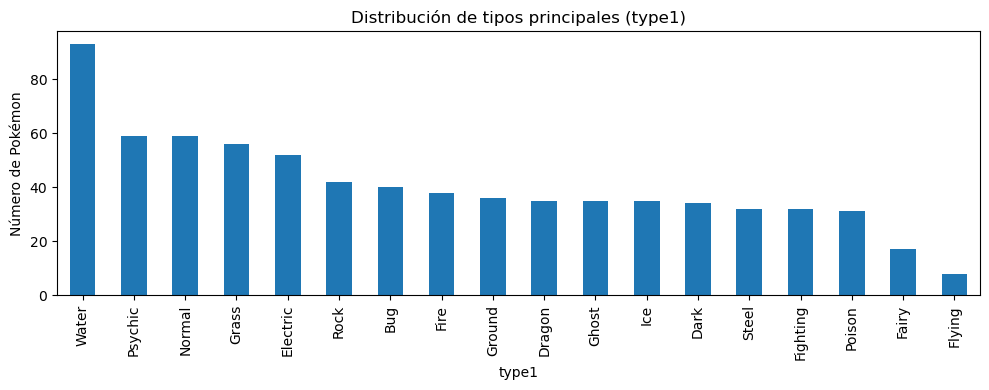

type1
Water       93
Psychic     59
Normal      59
Grass       56
Electric    52
Rock        42
Bug         40
Fire        38
Ground      36
Dragon      35
Name: count, dtype: int64

In [73]:
plt.figure(figsize=(10, 4))
df["type1"].value_counts().plot(kind="bar")
plt.title("Distribución de tipos principales (type1)")
plt.ylabel("Número de Pokémon")
plt.tight_layout()
plt.show()
df["type1"].value_counts().head(10)

La distribución de los tipos principales muestra que algunos tipos están claramente más representados en el conjunto de datos que otros. En particular, los tipos Water, Psychic, Normal y Grass concentran el mayor número de Pokémon, mientras que el resto de tipos presentan frecuencias progresivamente menores.

A continuación, se calculan las medias de las estadísticas base agrupadas por tipo principal, con el objetivo de identificar patrones generales y diferencias estructurales entre los distintos tipos de Pokémon.

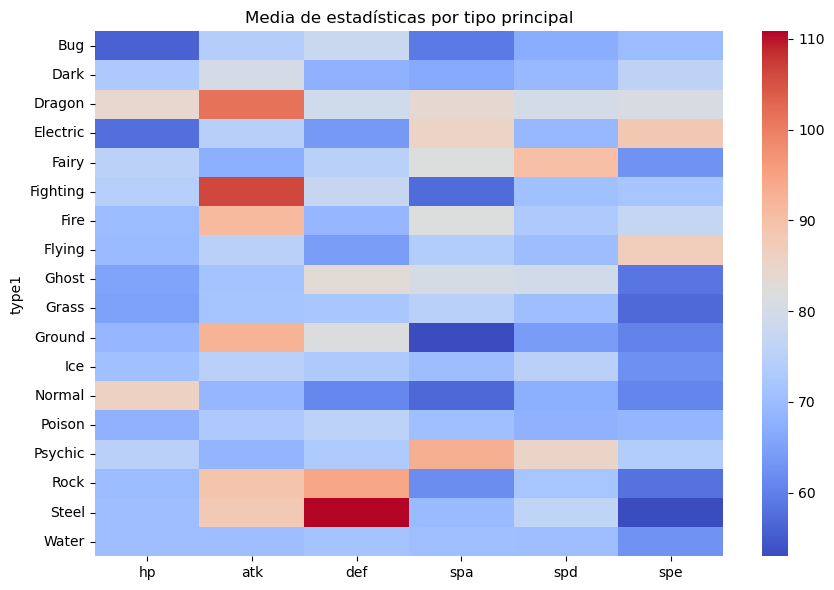

In [74]:
stat_cols = ["hp", "atk", "def", "spa", "spd", "spe"]

mean_stats = df.groupby("type1")[stat_cols].mean()

plt.figure(figsize=(9, 6))
sns.heatmap(mean_stats, cmap="coolwarm")
plt.title("Media de estadísticas por tipo principal")
plt.tight_layout()
plt.show()

Aquí se calcula la media de las estadísticas (hp, atk, def, spa, spd, spe) para cada tipo principal (type1) y se representa en un Heatmap. Cada fila es un tipo y cada columna una estadística. Los colores más cálidos indican valores medios más altos y los fríos más bajos. Este gráfico permite identificar qué tipos tienden a destacar en ciertos atributos y apoya la idea de si las características “fisiológicas” se asocian con el tipo.

Se puede observar que hay tipos que predominan en ciertas características (Ej. Steel y def, un mayor atk en tipos Fighting o Dragon) y otros que suelen tener valores más bajos en algunas de ellas (Ej. Ground y spa). También se aprecian tipos más robustos en general, con la mayoría de estadísticas con +80 (Dragon), y tipos más débiles, con muchas estadísticas en -80 (Bug o Normal).

Por último, se estudia la distribución de cada estadística base en función del tipo principal mediante diagramas de caja, lo que permite analizar no solo diferencias en la media, sino también la dispersión y la presencia de valores atípicos. Para evitar visualizaciones excesivamente densas y centrar el análisis en los tipos con mayor representación en el conjunto de datos, se seleccionan los 8 tipos principales más frecuentes.

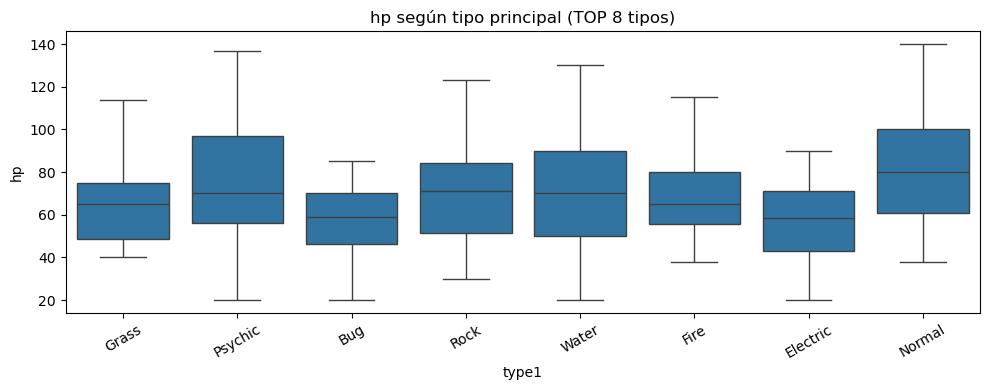

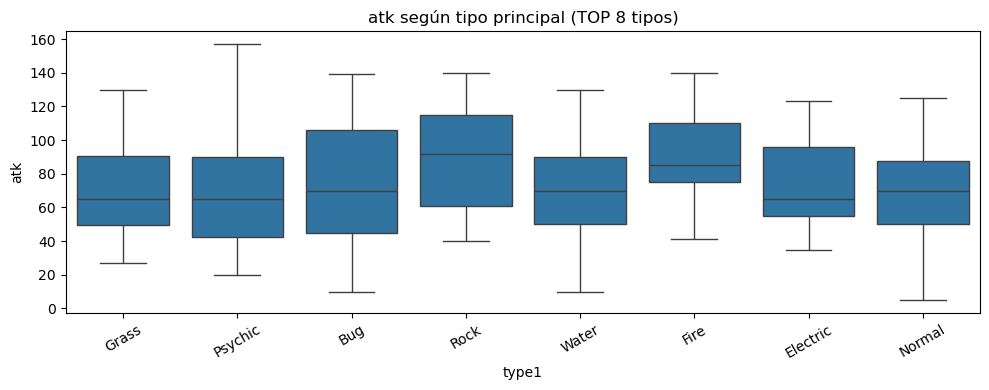

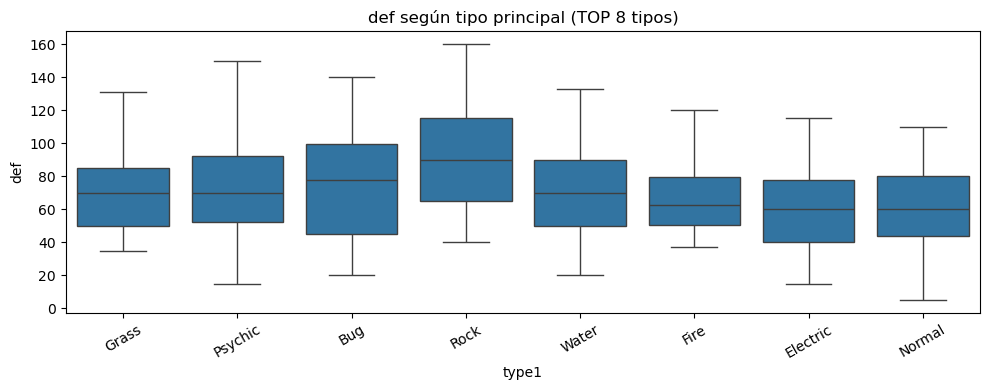

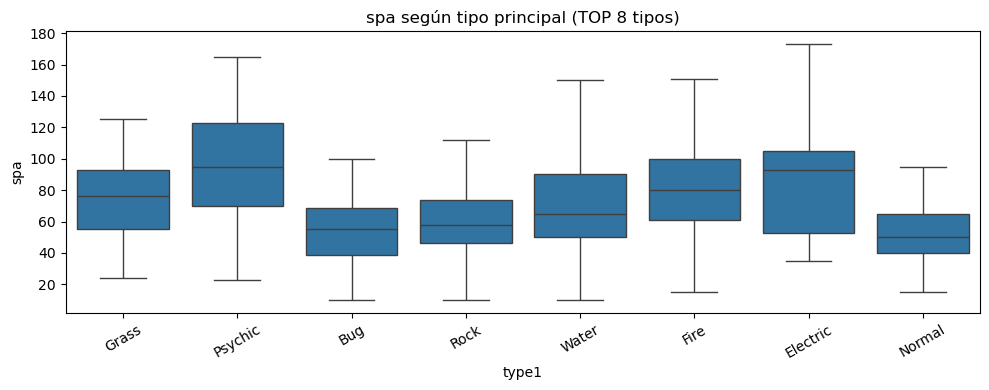

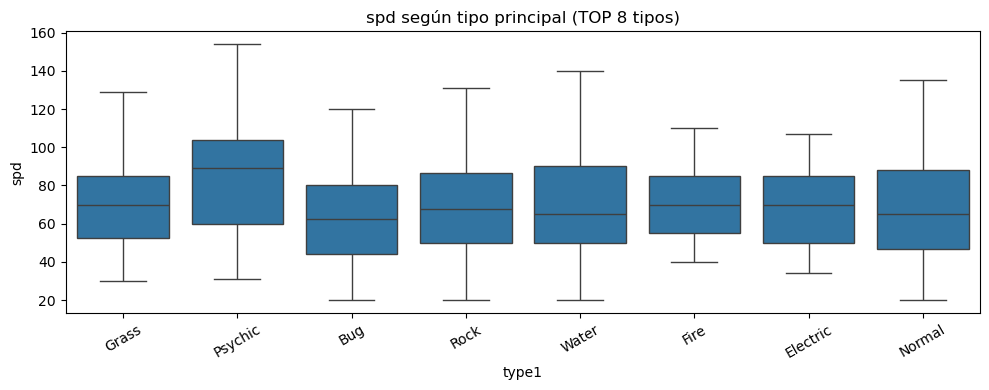

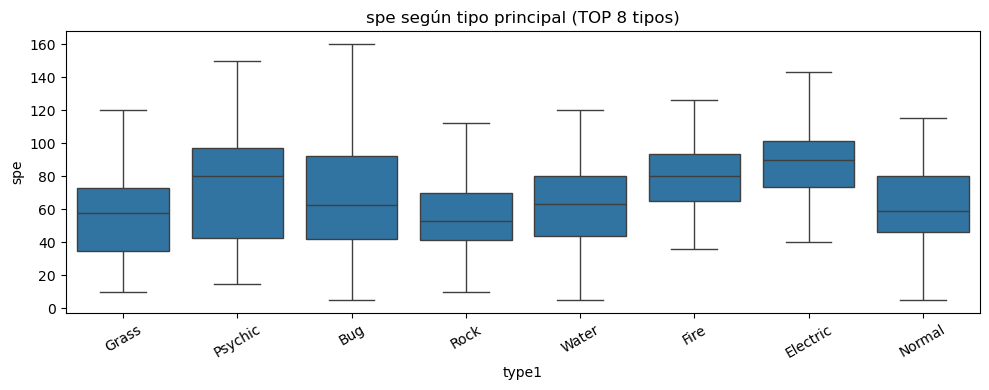

In [75]:
top_types = df["type1"].value_counts().head(8).index
df_top = df[df["type1"].isin(top_types)]

for col in stat_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(
        data=df_top,
        x="type1",
        y=col,
        showfliers=False
    )
    plt.title(f"{col} según tipo principal (TOP 8 tipos)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

En general, los gráficos muestran diferencias claras entre tipos, lo que sugiere que el tipo está, hasta cierto punto, relacionado con rasgos fisiológicos. Por ejemplo, se aprecia que Normal tiende a tener HP más alto en comparación con varios tipos, mientras que Bug suele presentar medianas más bajas en algunas estadísticas. También se observan perfiles característicos: Fire tiende a destacar en ataque, Psychic suele tener valores más altos en ataque especial (spa) y Electric aparece con velocidad (spe) relativamente alta. Además, la presencia de outliers indica que hay Pokémon “especiales” dentro de cada tipo, pero aun así las medianas y rangos diferencian bastante a los tipos. Esto apoya la idea de que los Pokémon podrían agruparse naturalmente según su tipo usando estas variables.

### Preprocesamiento de Datos

En esta sección se describen las tareas de preprocesamiento y transformación de los datos necesarias para preparar el conjunto de datos para la aplicación de algoritmos de clustering basados en distancia. Se justifican las decisiones relativas a la selección y transformación de características, el tratamiento de valores ausentes, la codificación de variables categóricas y el escalado de las variables numéricas.

#### Tratamiento de Valores Faltantes

In [76]:
df.isnull().sum()

hasEvo         0
hp             0
atk            0
def            0
spa            0
spd            0
spe            0
n_types        0
n_abilities    0
n_moves        0
types          0
abilities      0
learnset       0
type1          0
dtype: int64

Observamos que ninguna variable en nuestro dataframe presenta valores faltantes por lo cual no es necesario aplicar técnicas de imputación.

#### Tratamiento de Valores Atípicos

Aunque se observan valores extremos en algunas estadísticas, estos corresponden a Pokémon con características especiales y no a errores de medición. Dado que forman parte del dominio del problema y pueden aportar información relevante al proceso de clustering, no se aplica ningún tratamiento específico de eliminación o corrección de valores atípicos.

##### Escalado/Normalización

Dado que los algoritmos de clustering empleados en este trabajo se basan en el cálculo de distancias, es necesario escalar las variables numéricas para evitar que aquellas con mayor rango dominen el proceso de agrupamiento.

En esta celda se aplica StandardScaler para escalar todas las variables numéricas de X. El escalado deja cada característica con media 0 y desviación típica 1, evitando que variables con valores grandes dominen la distancia. Así, los datos quedan preparados para aplicar clustering de forma más equilibrada.

In [77]:
num_features = [
    "hp", "atk", "def", "spa", "spd", "spe",
    "hasEvo", "n_types", "n_abilities", "n_moves"
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_features])

X_scaled.shape

(734, 10)

#### Codificación de Variables Categóricas

Las variables categóricas del conjunto de datos, como los tipos, habilidades y movimientos, no se codifican explícitamente para su uso en el cálculo de distancias. Aunque estas variables podrían transformarse mediante técnicas como one-hot encoding, su naturaleza multivalor y la elevada dimensionalidad resultante dificultan la definición de una métrica de distancia interpretable y pueden introducir ruido en los algoritmos de clustering basados en distancia.

En particular, los tipos de Pokémon se reservan como información de dominio para la evaluación e interpretación posterior de los clusters, evitando que influyan directamente en su formación. Por su parte, las habilidades y el learnset se resumen mediante variables numéricas agregadas, lo que permite capturar información estructural relevante sin aumentar excesivamente la dimensionalidad. Esta decisión favorece una representación más compacta, interpretable y coherente con los objetivos del ejercicio.

## Paso 2 - Implementación

### K-Means

En esta sección se aplica el algoritmo de clustering K-Means con el objetivo de explorar cómo se agrupan naturalmente los Pokémon a partir de su representación numérica. Dado que K-Means requiere fijar previamente el número de clústeres, se evalúan distintos valores de k y se utilizan métricas empíricas para justificar la selección del número de clústeres más adecuado. En este ejercicio, utilizaremos los valores 2-10 (incluidos) como los valores de k. 

In [78]:
k_values = range(2, 11)

inertia = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

Como primera aproximación para seleccionar el valor óptimo de k, se utiliza el método del codo, que analiza la evolución de la inercia (suma de distancias cuadradas dentro de los clústeres) a medida que aumenta el número de clústeres. El valor de k óptimo suele identificarse en el punto donde la mejora deja de ser significativa.

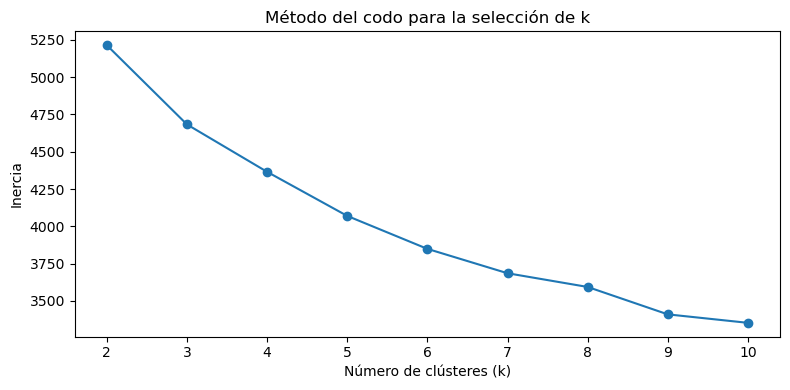

In [79]:
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Inercia")
plt.title("Método del codo para la selección de k")
plt.tight_layout()
plt.show()

La aplicación del método del codo muestra una disminución pronunciada de la inercia para valores bajos de k, especialmente entre k = 2 y k = 4. A partir de este punto, la reducción de la inercia se vuelve progresivamente más suave, indicando que el beneficio de aumentar el número de clústeres es cada vez menor. Este comportamiento sugiere la existencia de un punto de inflexión en torno a k = 4–5, a partir del cual añadir más clústeres no aporta mejoras significativas en la compacidad de los grupos.

Se complementa el análisis utilizando el Silhouette Score, que mide simultáneamente la cohesión interna de los clústeres y su separación. Valores más altos indican una mejor estructura de clustering.

In [80]:
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

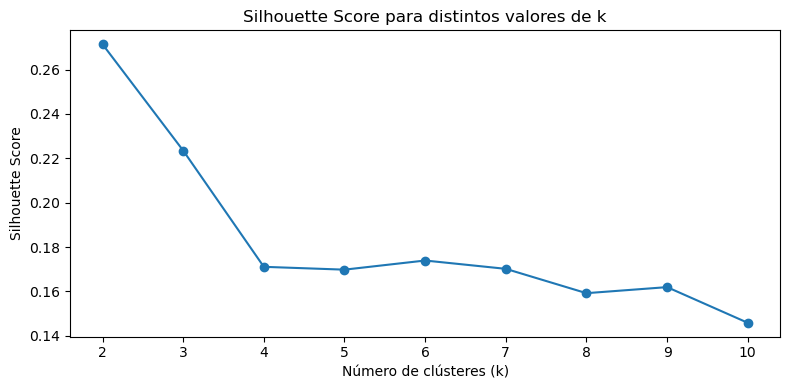

In [81]:
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score para distintos valores de k")
plt.tight_layout()
plt.show()

El análisis mediante el Silhouette Score muestra que el valor máximo se obtiene para k = 2, indicando que este número de clústeres produce la mejor combinación de cohesión interna y separación entre grupos. A partir de este valor, el Silhouette Score disminuye de forma notable, lo que sugiere que al incrementar el número de clústeres se produce una fragmentación de los datos que reduce la calidad del agrupamiento.

A partir del análisis empírico previo, se entrena el modelo final de K-Means utilizando k = 2, valor que maximiza el Silhouette Score y produce una separación clara entre grupos.

In [82]:
k_opt = 2

kmeans_final = KMeans(
    n_clusters=k_opt,
    random_state=42,
    n_init=10
)

labels_kmeans = kmeans_final.fit_predict(X_scaled)
df["cluster_kmeans"] = labels_kmeans

C:\Users\hguar\anaconda3\envs\Lab01_DM\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Tras entrenar el modelo final de K-Means con k = 2, se muestra el tamaño de los clústeres obtenidos.

In [83]:
cluster_sizes = pd.Series(labels_kmeans).value_counts().sort_index()
cluster_sizes

0    313
1    421
Name: count, dtype: int64

A continuación, se analizan los centroides del modelo final de K-Means, que representan el perfil medio de cada clúster en el espacio de características (a la escala original de las variables). De este modo podemos observar cada clúster en términos de estadísticas base y variables agregadas, y comparar directamente los perfiles de los clústeres obtenidos.

In [84]:
centroids_scaled = kmeans_final.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids, columns=num_features)
centroids_df

,hp,atk,def,spa,spd,spe,hasEvo,n_types,n_abilities,n_moves
0,52.495208,57.322684,56.281150,51.581470,52.501597,52.376997,0.955272,1.440895,2.527157,47.105431
1,83.954869,94.315914,89.365796,86.795724,87.543943,78.513064,0.019002,1.622328,2.237530,57.686461


La tabla de centroides muestra diferencias claras entre los dos clústeres identificados por el modelo K-Means. El clúster 0 presenta valores medios más bajos en todas las estadísticas base, así como un mayor valor medio de hasEvo, lo que sugiere que agrupa principalmente Pokémon más débiles o en etapas evolutivas tempranas. Por el contrario, el clúster 1 se caracteriza por valores medios significativamente más altos en las estadísticas de ataque, defensa, ataque especial y velocidad, y una proporción muy reducida de Pokémon con evolución pendiente, lo que indica un grupo compuesto mayoritariamente por Pokémon más fuertes o completamente evolucionados. Estas diferencias reflejan una separación coherente entre Pokémon de bajo y alto rendimiento estadístico.

Por último, mostramos el Silhouette Score obtenido para el valor k=2.

In [85]:
silhouette_final = silhouette_score(X_scaled, labels_kmeans)
silhouette_final

0.27141395020397535

El valor del silhouette score (0,27) indica una separación moderada entre clústeres, lo que sugiere la presencia de cierta estructura subyacente en los datos, aunque con solapamientos. Este resultado representa el mejor equilibrio observado entre cohesión y separación al comparar distintos valores de k.

### DBSCAN

En esta sección se aplica el algoritmo de clustering DBSCAN, un método basado en densidad que no requiere fijar previamente el número de clústeres y permite identificar automáticamente regiones densas y posibles valores atípicos. A diferencia de K-Means, DBSCAN es capaz de detectar clústeres de forma arbitraria y separar instancias que no pertenecen a ninguna región densa. Utilizaremos distintas combinaciones de los parámetros eps y min_samples, evaluando empíricamente la calidad de los clústeres obtenidos.

Como primera aproximación para seleccionar valores razonables de eps, se utiliza el gráfico de distancias al k-ésimo vecino más cercano. Este método permite identificar visualmente un punto de inflexión que separa regiones densas de regiones dispersas.

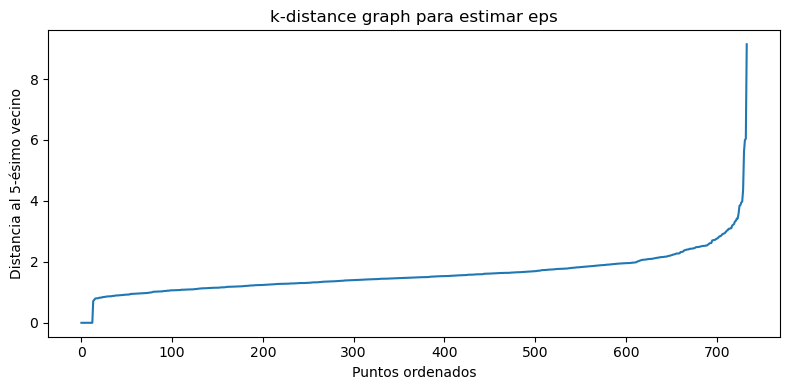

In [86]:
# Número de vecinos
k = 5

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}-ésimo vecino")
plt.title("k-distance graph para estimar eps")
plt.tight_layout()
plt.show()

El gráfico de distancias al 5º vecino muestra una región inicial con un crecimiento suave de la distancia, seguida de un incremento rápido en la parte final de la curva. Este punto de inflexión separa las regiones densas de los puntos más aislados y sugiere un valor razonable de eps. A partir de esta observación, se selecciona un rango de valores de eps para la implementación y evaluación del modelo DBSCAN.

Sobre esta base, se realiza un análisis de distintas combinaciones de eps y min_samples con el objetivo de analizar cómo varía la estructura de los clústeres, la cantidad de ruido detectado y la calidad del agrupamiento mediante la métrica Silhouette Score.

In [87]:
# Rango de parámetros basado en el k-distance graph
eps_values = [1.8, 2.0, 2.2, 2.5, 3.0]
min_samples_values = [3, 5, 10]

results = []

for eps in eps_values:
    for min_s in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        labels = dbscan.fit_predict(X_scaled)

        # Número de clústeres
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Silhouette Score (solo si hay al menos 2 clústeres)
        if n_clusters > 1:
            sil = silhouette_score(X_scaled, labels)
        else:
            sil = np.nan

        results.append({
            "eps": eps,
            "min_samples": min_s,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil
        })

# Resumen de resultados en formato tabla
results_df = pd.DataFrame(results)
results_df

,eps,min_samples,n_clusters,n_noise,silhouette
0,1.8,3,9,80,0.103596
1,1.8,5,6,106,0.117911
2,1.8,10,4,149,0.109593
3,2.0,3,9,61,0.110107
4,2.0,5,7,73,0.131979
5,2.0,10,4,100,0.132951
6,2.2,3,4,41,0.120733
7,2.2,5,3,51,0.119333
8,2.2,10,1,66,NaN
9,2.5,3,2,27,0.210873


El análisis de los parámetros de DBSCAN muestra que valores bajos de eps producen una fragmentación excesiva del espacio de datos, generando muchos clústeres pequeños y una proporción elevada de puntos clasificados como ruido. Por el contrario, valores elevados de eps (eps > 3 aproximadamente) provocan la fusión de todas las instancias en un único clúster.

La mejor configuración se obtiene para eps = 2.5, donde el algoritmo identifica dos clústeres bien definidos y una cantidad reducida de ruido con respecto al resto de configuración de parámetros. Lsa combinaciones de eps = 2.5 y min_samples = 3/min_samples = 5 presentan valores de Silhouette Score casi idénticos. Dado que el valor de min_samples 3 presenta un valor ligeramente superior de Silhouette Score frente a min_samples 5, 0.210873 y 0.210714 respectivamente, la configuración con eps = 2.5 y min_samples = 3 se selecciona como la óptima para el modelo DBSCAN.

A continuación entrenamos el modelo DBSCAN con las configuraciones óptimas definidas anteriormente. 

In [88]:
# Parámetros óptimos según la exploración empírica
eps_opt = 2.5
min_samples_opt = 3

# Entrenamiento del modelo final
dbscan_final = DBSCAN(eps=eps_opt, min_samples=min_samples_opt)
labels_dbscan = dbscan_final.fit_predict(X_scaled)

# Añadir etiquetas al DataFrame
df["cluster_dbscan"] = labels_dbscan

n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)

n_clusters_dbscan, n_noise_dbscan

(2, 27)

## Paso 3 - Evaluación

En esta sección se evalúan y comparan los resultados obtenidos con los algoritmos K-Means y DBSCAN, analizando su capacidad para descubrir estructuras significativas en el conjunto de datos de Pokémon. Se estudian las diferencias entre ambos enfoques en términos de estructura de clústeres, interpretabilidad y detección de patrones relevantes, apoyándose en la evidencia empírica obtenida durante la fase de implementación.

### Comparativa K-Means y DBSCAN

El modelo K-Means de mayor rendimiento, con k = 2, produce una estructura de clústeres simple y bien definida, dividiendo el conjunto de datos en dos grupos claramente diferenciados. Los clústeres obtenidos son compactos, de tamaño equilibrado y fácilmente interpretables a partir de sus centroides, lo que permite describirlos como grupos de Pokémon con estadísticas globalmente bajas frente a Pokémon con estadísticas significativamente más altas. Esta estructura se refleja en un Silhouette Score relativamente elevado y estable, lo que indica una buena separación global entre los grupos.

Por su parte, el modelo DBSCAN con parámetros óptimos (eps = 2.5, min_samples = 3) también identifica dos clústeres principales, pero añade la capacidad de detectar puntos atípicos que no pertenecen a ninguna región densa. Desde el punto de vista estructural, DBSCAN ofrece una representación más flexible al no imponer una forma esférica ni un número fijo de clústeres. Sin embargo, aunque logra una buena separación en su configuración óptima, el número de clústeres y la cantidad de ruido detectado resultan muy sensibles a pequeñas variaciones en los parámetros, lo que dificulta la estabilidad y reproducibilidad del modelo.

Desde el punto de vista de las métricas empíricas, el Silhouette Score refuerza las conclusiones anteriores. El modelo K-Means con k = 2 alcanza un valor de Silhouette superior al obtenido por DBSCAN en su mejor configuración, lo que indica una mayor cohesión interna de los clústeres y una mejor separación global entre ellos. Aunque DBSCAN logra valores de Silhouette razonables en su configuración óptima (eps = 2.5, min_samples = 3), estos son ligeramente inferiores y más sensibles a la elección de parámetros. Esto sugiere que, para este conjunto de datos, K-Means proporciona una estructura de agrupamiento más estable y consistente según criterios cuantitativos.

### ¿Los clústeres se alinean con los tipos elementales?

Para observar si los clústeres se alinean con los tipos elementales de Pokémon, a continuación representaremos la distribución de los 10 tipos de Pokémon mas frecuentes dentro de cada clúster con la finalidad de analizar la proporción de cada tipo dentro de cada clúster y de este modo visualizar si a partir de las estadísticas base y variables derivada del dataset original el modelo K-Mean ha agrupado, o no, los Pokémon a partir de su tipo (y entre otras características comunes). 

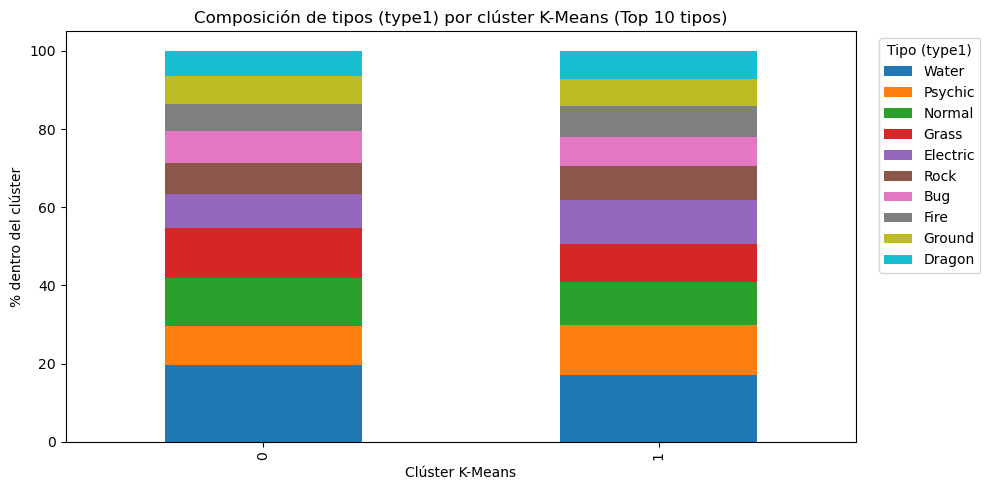

type1,Water,Psychic,Normal,Grass,Electric,Rock,Bug,Fire,Ground,Dragon
cluster_kmeans,,,,,,,,,,
0,19.6,10.0,12.3,12.8,8.7,7.8,8.2,6.8,7.3,6.4
1,17.2,12.7,11.0,9.6,11.3,8.6,7.6,7.9,6.9,7.2


In [89]:
if "type1" not in df.columns:
    df["type1"] = df["types"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)

# Utilizamos los 10 tipos más frecuentes
topN = 10
top_types = df["type1"].value_counts().head(topN).index

# Tabla de conteos por cluster y tipo de Pokémon
ct = pd.crosstab(df["cluster_kmeans"], df["type1"])
ct_top = ct[top_types]

# Porcentaje dentro de cada cluster
ct_top_pct = ct_top.div(ct_top.sum(axis=1), axis=0) * 100

# Gráfico de barras
ax = ct_top_pct.plot(kind="bar", stacked=True, figsize=(10, 5))
ax.set_title(f"Composición de tipos (type1) por clúster K-Means (Top {topN} tipos)")
ax.set_xlabel("Clúster K-Means")
ax.set_ylabel("% dentro del clúster")
plt.legend(title="Tipo (type1)", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Tabla de porcentajes
ct_top_pct.round(1)

La figura muestra la composición porcentual de los tipos principales dentro de cada clúster generado por el modelo K-Means. Se observa que ambos clústeres presentan distribuciones de tipos muy similares, sin que ningún tipo elemental domine claramente un clúster específico. Por ejemplo, tipos como Water, Psychic, Normal o Grass aparecen en proporciones comparables en ambos grupos, y las diferencias porcentuales entre clústeres son relativamente pequeñas.

Esta distribución indica que los clústeres no están organizados principalmente en función del tipo elemental, lo que es coherente con el diseño del experimento, ya que los tipos no se utilizaron como variables de entrada durante el entrenamiento del modelo. En su lugar, los clústeres se formaron a partir de características observables cuantitativas, como las estadísticas base y las variables derivadas (por ejemplo, número de habilidades o movimientos).

No obstante, el hecho de que algunos tipos presenten ligeras variaciones entre clústeres sugiere que el tipo puede estar indirectamente relacionado con los patrones detectados, en la medida en que ciertos tipos tienden a compartir perfiles estadísticos similares. Sin embargo, estos efectos no son lo suficientemente fuertes como para afirmar que el tipo elemental sea un predictor dominante de los grupos obtenidos.

En conjunto, los resultados indican que el principal factor de agrupamiento es el perfil estadístico global de los Pokémon, más que su taxonomía elemental. Esto sugiere que, aunque el tipo influye en el diseño de las estadísticas, no determina por sí solo la estructura de los clústeres, y que las características numéricas capturan patrones más generales relacionados con el rendimiento o el rol del Pokémon.

### ¿Qué características contribuyen más a la formación de los clústeres?

A continuación, se analiza qué variables numéricas separan con mayor fuerza los grupos obtenidos. Esto permite entender qué aspectos observables (estadísticas y variables derivadas) explican la estructura de clústeres hallada por el algoritmo.

Se emplea un heatmap de medias por clúster porque resume de forma compacta el perfil característico de cada grupo y facilita comparar patrones entre clústeres. Además, el barplot de diferencias ayuda a identificar rápidamente qué variables separan más los grupos, apoyando la interpretación del clustering con evidencia cuantitativa.

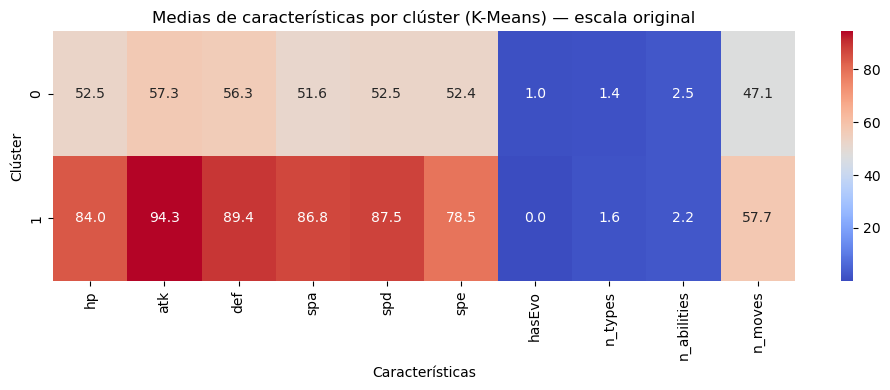

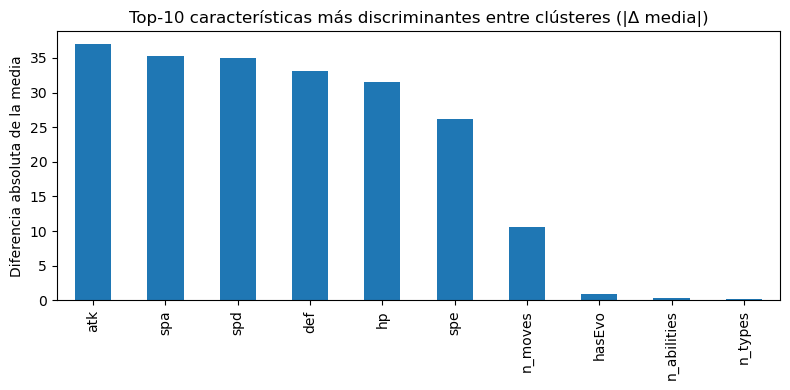

atk            36.993231
spa            35.214255
spd            35.042346
def            33.084646
hp             31.459662
spe            26.136067
n_moves        10.581029
hasEvo          0.936269
n_abilities     0.289627
n_types         0.181433
dtype: float64

In [90]:
cluster_means = df.groupby("cluster_kmeans")[num_features].mean()

# Mapa de calor para comparar las estadísticas medias de cada clúster
plt.figure(figsize=(10, 4))
sns.heatmap(cluster_means, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Medias de características por clúster (K-Means) — escala original")
plt.xlabel("Características")
plt.ylabel("Clúster")
plt.tight_layout()
plt.show()

# Ranking de variables más discriminantes
diff = (cluster_means.loc[1] - cluster_means.loc[0]).abs().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
diff.head(10).plot(kind="bar")
plt.title("Top-10 características más discriminantes entre clústeres (|Δ media|)")
plt.ylabel("Diferencia absoluta de la media")
plt.tight_layout()
plt.show()

# Mayores diferencias entre estadísticas medias de cada clúster - variables más discriminantes
diff.head(10)

La comparación de medias por clúster muestra que la separación entre grupos está dominada principalmente por las estadísticas base. En el heatmap se observa que el clúster 1 presenta valores medios significativamente superiores en todas las estadísticas (hp, atk, def, spa, spd, spe) respecto al clúster 0, lo que sugiere que el modelo está distinguiendo entre Pokémon con mayor “potencia estadística” global frente a Pokémon con estadísticas más bajas. Esta conclusión se refuerza cuantitativamente con el ranking de diferencias de medias, donde las variables con mayor capacidad discriminante son atk, spa, spd, def, hp y spe, todas con diferencias amplias (≈ 26–37 puntos), muy por encima del resto de atributos.

Aunque hasEvo presenta una diferencia de medias numéricamente pequeña en términos absolutos (≈ 0.93), su interpretación es especialmente relevante porque se trata de una variable binaria (solo puede tomar 0 o 1). En este contexto, una diferencia cercana a 1 implica una separación casi completa entre clústeres: el clúster 0 tiene una media de hasEvo próxima a 1, lo que indica que la gran mayoría de Pokémon en ese grupo sí tienen evolución, mientras que el clúster 1 tiene una media cercana a 0, lo que sugiere que la gran mayoría de Pokémon en ese grupo no tienen evolución.

Este resultado es coherente con la interpretación general de los clústeres basada en las estadísticas: los Pokémon con evolución pendiente tienden a incluir formas previas o intermedias, que suelen presentar estadísticas medias más bajas, mientras que los Pokémon que no tienen evolución suelen corresponder a formas finales o casos especiales con perfiles estadísticos más altos. Por tanto, aunque las estadísticas base son el principal factor de separación, hasEvo actúa como un indicador estructural que refuerza la idea de que el clustering está capturando una diferencia entre Pokémon “en desarrollo” y Pokémon “más completos” o consolidados.

En relación con las suposiciones sobre la taxonomía de Pokémon, estos resultados respaldan parcialmente la idea de que existen patrones coherentes en las estadísticas (por ejemplo, ciertos tipos tienden a tener perfiles distintos), pero también la cuestionan como criterio dominante de agrupación. El hecho de que los clústeres se expliquen casi por completo por estadísticas base sugiere que la estructura descubierta refleja un patrón global de rendimiento que atraviesa múltiples tipos elementales. Es decir, los tipos pueden influir en el diseño de las estadísticas, pero en este conjunto de datos no parecen ser el eje principal de separación cuando se agrupa únicamente por variables numéricas observables.

### Etiquetas y Descripción de Características de tres grupos Diferentes

Para convertir los clústeres en categorías interpretables (como en un problema de clasificación), se describen perfiles característicos. Además de los dos clústeres principales, se define un tercer grupo dentro del clúster de mayor potencia (estadísticas base más altas) para diferenciar estilos de combate (físico vs especial).

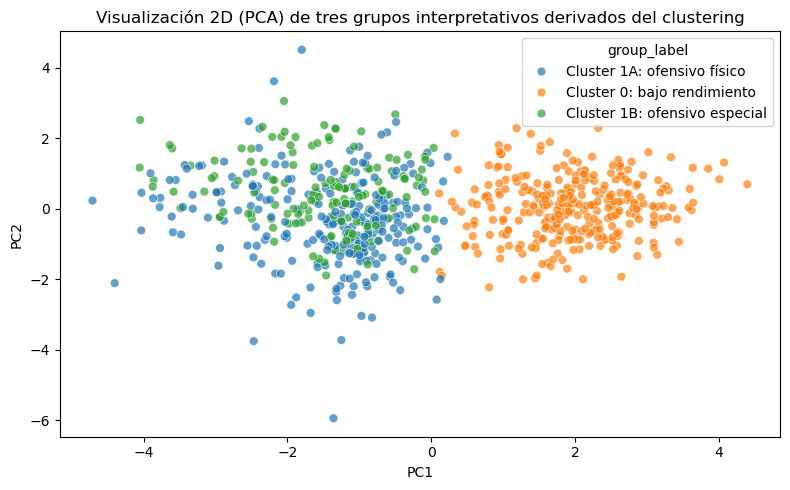

(group_label
 Cluster 0: bajo rendimiento      313
 Cluster 1A: ofensivo físico      257
 Cluster 1B: ofensivo especial    164
 Name: count, dtype: int64,
                                  hp    atk   def    spa   spd   spe  hasEvo  \
 group_label                                                                   
 Cluster 0: bajo rendimiento    52.5   57.3  56.3   51.6  52.5  52.4     1.0   
 Cluster 1A: ofensivo físico    84.8  106.8  95.8   72.5  83.0  77.0     0.0   
 Cluster 1B: ofensivo especial  82.6   74.8  79.3  109.2  94.7  80.9     0.0   
 
                                n_types  n_abilities  n_moves  
 group_label                                                   
 Cluster 0: bajo rendimiento        1.4          2.5     47.1  
 Cluster 1A: ofensivo físico        1.6          2.3     58.5  
 Cluster 1B: ofensivo especial      1.6          2.2     56.4  )

In [91]:
df["group_label"] = "Cluster 0: bajo rendimiento"

mask_c1 = df["cluster_kmeans"] == 1
df.loc[mask_c1, "group_label"] = "Cluster 1: alto rendimiento"

mask_physical = mask_c1 & (df["atk"] >= df["spa"])
mask_special  = mask_c1 & (df["spa"] > df["atk"])

df.loc[mask_physical, "group_label"] = "Cluster 1A: ofensivo físico"
df.loc[mask_special,  "group_label"] = "Cluster 1B: ofensivo especial"

# PCA solo para visualizar en 2D (no se usa para entrenar)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df.index)
pca_df["group_label"] = df["group_label"].values

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="group_label", alpha=0.7, s=40)
plt.title("Visualización 2D (PCA) de tres grupos interpretativos derivados del clustering")
plt.tight_layout()
plt.show()

# Resumen numérico de cada grupo (medias)
group_means = df.groupby("group_label")[num_features].mean().round(1)
group_sizes = df["group_label"].value_counts()

group_sizes, group_means

La figura muestra una proyección en 2D mediante PCA del espacio de características (10 variables numéricas) y se utiliza para visualizar e interpretar tres perfiles de Pokémon derivados del clustering (cluster0 - estadísticas base bajas, cluster1 - estadísticas base altas y un tercer grupo derivado del cluster 1 a partir del estilo de combate).

En la proyección se observa que existe un grupo claramente diferenciado (en naranja), correspondiente al “Cluster 0: bajo rendimiento”, que aparece relativamente separado del resto. Este resultado es coherente con las medias mostradas: este grupo presenta estadísticas base significativamente más bajas (por ejemplo hp, atk, def, spa, spd y spe alrededor de ~50–60) y, además, tiene hasEvo ≈ 1, lo que indica que la mayoría de Pokémon en este grupo sí tienen evolución (formas previas/intermedias). En contraste, los otros dos grupos (azul y verde) se solapan parcialmente entre sí en el plano PCA, pero ambos se sitúan en la región opuesta a PC1 y corresponden a perfiles de alto rendimiento, con hasEvo ≈ 0 (principalmente Pokémon en formas finales con más potencia).

La separación en dos subgrupos dentro del clúster de mayor rendimiento aporta una interpretación adicional basada en estilo de combate: el “Cluster 1A: ofensivo físico” presenta un atk medio claramente más alto que spa, mientras que el “Cluster 1B: ofensivo especial” muestra el patrón contrario, con spa notablemente superior a atk. Aunque ambos grupos comparten un nivel general de estadísticas alto, esta diferenciación permite asignar etiquetas semánticas como en un problema de clasificación.